In [219]:
import pandas as pd
import seaborn as sns
import numpy as np

In [ ]:
df = pd.read_csv("/data/6 class csv.csv")
df.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


In [221]:
#We change the names of the columns to make them easier to handle
original_names=df.columns.values
new_names=['temperature','luminosity','radius','absolute_mag','type','color','spec_class']
mapper=dict(zip(original_names, new_names))
df=df.rename(mapper, axis=1)
df['color']=df['color'].astype('category')
df['type']=pd.Categorical.from_codes(df['type'], 
                                    categories=['Red Dwarf','Brown Dwarf', 'White Dwarf', 'Main Sequence' , 'Super Giant', 'Hyper Giant'])
df['spec_class']=df['spec_class'].astype('category')
dict(enumerate(df['spec_class'].cat.categories))
df['spec_class']=df['spec_class'].cat.reorder_categories(['M','K','G','F','A','B','O'], ordered=True)

In [222]:
df['spec_class'].dtype

CategoricalDtype(categories=['M', 'K', 'G', 'F', 'A', 'B', 'O'], ordered=True, categories_dtype=object)

In [223]:
color_map = {
    'Blue white': 'Blue-White',
    'blue-white': 'Blue-White',
    'Blue white ': 'Blue-White',
    'Blue-White': 'Blue-White',
    'Blue-white' : 'Blue-White',
    'Blue White': 'Blue-White',
    
    'White': 'White',
    'white': 'White',
    'Whitish': 'White',
    
    'Yellowish White': 'Yellow-White',
    'yellow-white': 'Yellow-White',
    'White-Yellow': 'Yellow-White',
    
    'Blue': 'Blue',
    'Blue ': 'Blue',
    
    'Red': 'Red',
    
    'Orange': 'Orange',
    'Orange-Red': 'Orange',
    
    'yellowish': 'Yellow',
    'Yellowish': 'Yellow',
    
    'Pale yellow orange': 'Yellow-Orange'
}


df['color'] = df['color'].replace(color_map)

C:\Users\laiba\AppData\Local\Temp\ipykernel_7164\3327010673.py:32: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['color'] = df['color'].replace(color_map)


In [224]:
stars = df.copy()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report

target_cats=stars.type.cat.categories.tolist()

split=StratifiedShuffleSplit(n_splits=1,test_size=0.50 ,random_state=10)
for train_index, test_index in split.split(stars, stars['type']):
    stars_train=stars.loc[train_index]
    stars_test=stars.loc[test_index]


predictor_mask=stars.columns!='type'
target_mask=stars.columns=='type'

ordinal_cats=['spec_class']
nominal_cats=['color']

pipeline= ColumnTransformer([
    ('ord_cat',OrdinalEncoder(),ordinal_cats),
    ('nom_cat',OneHotEncoder(sparse_output=False),nominal_cats)],
    remainder='passthrough')

X_train=stars_train.loc[:,predictor_mask]
y_train=stars_train['type'].cat.codes

X_test=stars_test.loc[:,predictor_mask]
y_test=stars_test['type']

pipeline.fit(stars.loc[:,predictor_mask])

X_train_processed=pipeline.transform(X_train)
X_test_processed=pipeline.transform(X_test)


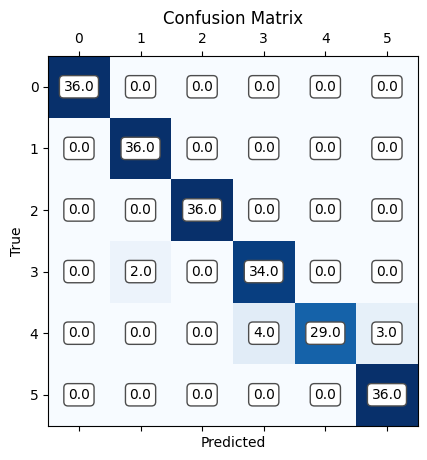

               precision    recall  f1-score   support

    Red Dwarf       1.00      1.00      1.00        36
  Brown Dwarf       0.95      1.00      0.97        36
  White Dwarf       1.00      1.00      1.00        36
Main Sequence       0.89      0.94      0.92        36
  Super Giant       1.00      0.81      0.89        36
  Hyper Giant       0.92      1.00      0.96        36

     accuracy                           0.96       216
    macro avg       0.96      0.96      0.96       216
 weighted avg       0.96      0.96      0.96       216



In [226]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Initialize the Logistic Regression model
logreg = DecisionTreeClassifier()

# Fit the model on the entire training set
logreg.fit(X_train_processed, y_train)

# Predict on the test set
y_test_predict = logreg.predict(X_test_processed)

# Compute the confusion matrix
conf_mat = confusion_matrix(y_test.cat.codes, y_test_predict)

# Plot the confusion matrix
fig, ax = plt.subplots()
ax.matshow(conf_mat, cmap='Blues')

# Annotate the confusion matrix with the values
for (i, j), z in np.ndenumerate(conf_mat):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report for the test set
report = classification_report(y_test.cat.codes, y_test_predict, target_names=stars.type.cat.categories.tolist())
print(report)
